In [1]:
# Attention: im dataset sind englische texte vorhanden

In [1]:
from time import time
import math
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer as skTfidf
import cupy as cp           #use cupy array instead of numpy to speed up calculation by using GPU
import cudf as cf
from cuml.metrics.pairwise_distances import sparse_pairwise_distances
from cuml.feature_extraction.text import TfidfVectorizer as cuTfidf
from cuml.metrics.pairwise_distances import pairwise_distances


import matplotlib.pyplot as plt
import sys

# read corpus.csv and basic analysis show:
- there are 985 exam types
- majority of the exam types have less than 2000 documents
- top 3 percentile of exam types hold the most amount of documents ->
- after filtering we still have
    - 175724 out of 2590588 entries: df_filtered / original corpus: 0.6783174321814198
    - number of exam types after filtering: 30

    

In [3]:
df = pd.read_csv('/home/test/data/corpus.csv', encoding='utf-16', index_col='id')
df.drop([df.columns[0]], inplace=True, axis=1)
df.columns
# number of exam types
len(set(df['exam_type']))

985

In [4]:
exam_type_distribution = df.groupby(['exam_type'])['exam_type'].count()
exam_type_distribution.sort_values(ascending=False)

exam_type
ARRT          475040
ARRTRBS       449462
ARSB          125930
ARCK          101225
ARRWXEBLWS     63649
               ...  
ARKEKMXUGB         1
ARKEKMXUFB         1
ARKBKMXSIG         1
ARKBKMXNIB         1
ARNPMYOFDG         1
Name: exam_type, Length: 984, dtype: int64

In [5]:
exam_type_distribution.describe()

count       984.000000
mean       2276.918699
std       21858.631776
min           1.000000
25%           3.000000
50%          13.000000
75%         143.250000
max      475040.000000
Name: exam_type, dtype: float64

(array([122.,   2.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([  1023. ,  48424.7,  95826.4, 143228.1, 190629.8, 238031.5,
        285433.2, 332834.9, 380236.6, 427638.3, 475040. ]),
 <BarContainer object of 10 artists>)

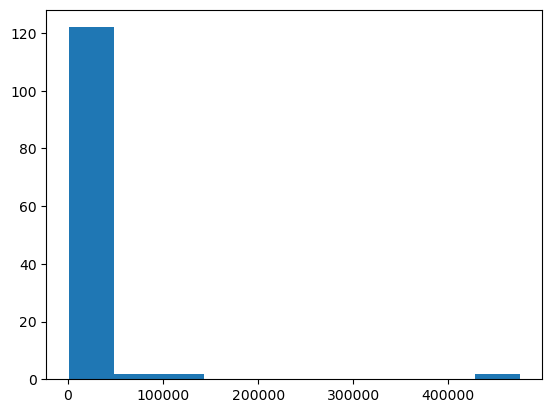

In [6]:
plt.hist(exam_type_distribution[exam_type_distribution > 1000].values)

In [7]:
len(exam_type_distribution[exam_type_distribution < 10000]) / len(set(df['exam_type']))

0.9593908629441624

In [8]:
print('Exam types with less than 10 documents: ', len(exam_type_distribution[exam_type_distribution < 10]))
print('Exam types with less than 100 documents: ', len(exam_type_distribution[exam_type_distribution < 100]))
print('Exam types with less than 1000 documents: ', len(exam_type_distribution[exam_type_distribution < 1000]))
print('Exam types with less than 10000 documents: ', len(exam_type_distribution[exam_type_distribution < 10000]))
print('out of total types of exams  945 / 984', len(exam_type_distribution[exam_type_distribution < 10000]) / len(set(df['exam_type'])))

Exam types with less than 10 documents:  447
Exam types with less than 100 documents:  707
Exam types with less than 1000 documents:  856
Exam types with less than 10000 documents:  945
out of total types of exams  945 / 984 0.9593908629441624


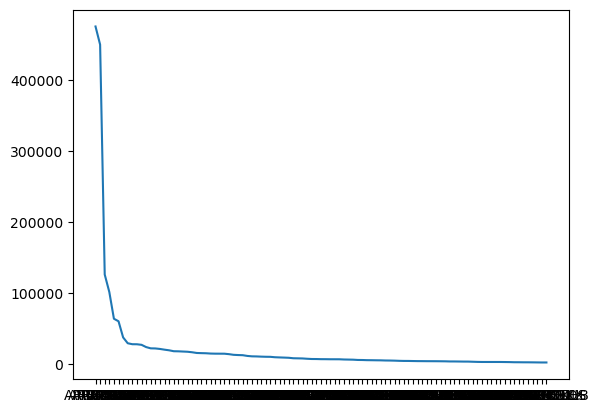

In [9]:
plt.plot(exam_type_distribution[exam_type_distribution > np.percentile(exam_type_distribution, 90)].sort_values(ascending=False))

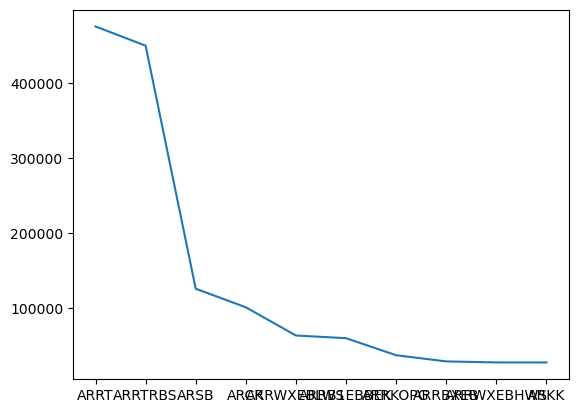

In [10]:
plt.plot(exam_type_distribution[exam_type_distribution > np.percentile(exam_type_distribution, 99)].sort_values(ascending=False))

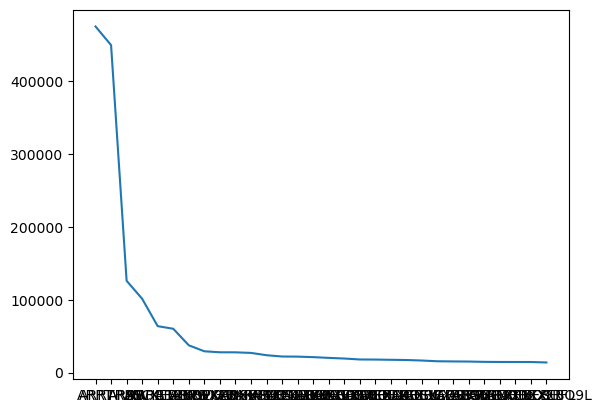

In [11]:
# 97th percentile
plt.plot(exam_type_distribution[exam_type_distribution > np.percentile(exam_type_distribution, 97)].sort_values(ascending=False))

In [12]:
# Set your desired filter threshold here: (97% used in this notebook)
filter_value = np.percentile(exam_type_distribution, 97)

In [13]:
np.percentile(exam_type_distribution, 90)

2098.0000000000005

In [14]:
list_filtered = exam_type_distribution[exam_type_distribution > filter_value]
df_filtered = df[df['exam_type'].isin(list_filtered.index)]

In [15]:
print(f'original dataframe shape: {df.shape}')
print(f'df_filtered shape: {df_filtered.shape}')
print(f'df_filtered / original: {df_filtered.shape[0] / df.shape[0]}')
print(f'number of exam types after filtering: {len(set(df_filtered["exam_type"]))}')
list_filtered.sort_values(ascending=False).to_frame()

original dataframe shape: (2590588, 4)
df_filtered shape: (1757241, 4)
df_filtered / original: 0.6783174321814198
number of exam types after filtering: 30


,exam_type
exam_type,
ARRT,475040
ARRTRBS,449462
ARSB,125930
ARCK,101225
ARRWXEBLWS,63649
ARRB1EBBEK,60102
ARRKOPG,37380
ARRBXEB,29170
ARRWXEBHWS,27806


In [16]:
df_filtered

,text,words,accession_number,exam_type
id,,,,
4,Orthopantomographie vom Klinik Fragestellun...,52,9143773.0,ARRKOPG
5,Thorax bed side auf Station vom Uhr Klinik...,76,9143455.0,ARRTRBS
6,CT BWS vom CT ergänzende Serie vom Klinik ...,88,9143657.0,ARCW
8,Thorax bed side auf Station vom Uhr Klinik...,57,9143413.0,ARRTRBS
11,Teleradiologische Befundung vom Klinik Frage...,101,9143787.0,ARXXTLE
...,...,...,...,...
4504138,Sonographie Nieren vom Anamnese Abklärung M...,75,7187414.0,ARSBSNONIX
4504140,Sonographie gesamtes Abdomen vom Befund Insg...,63,7173534.0,ARSB
4504142,Thorax bed side auf Station vom Uhr Anamnes...,60,7187879.0,ARRTRBS


# create a new dataframe with the filtered exam types and their closest matches


In [17]:
# create a function to wrap the for choice in choices loop
# input: - dataframe (df), 
#        - filter_value for minimum number of documents per exam type, 
#        - # ngrams for tfIdf vectorizer, default(1,1) for bigram use (2,2) 
#        - batch_size to manage distance calculation, default 12500
#        - upper and lowerbound to save the results, default 0.2 and 0.001
# output: - dictionary with the results

In [6]:
def load_frame(path_to_df='/home/test/data/corpus.csv', encoding='utf-16', filter_value = 100000):
    
    df= pd.read_csv(path_to_df, encoding=encoding, index_col='id')
    df.drop([df.columns[0]], inplace=True, axis=1)
    
    exam_type_distribution = df.groupby(['exam_type'])['exam_type'].count()
    exam_type_distribution.sort_values(ascending=False)
    
    list_filtered = exam_type_distribution[exam_type_distribution > filter_value].index
    df_filtered = df[df['exam_type'].isin(list_filtered)]
    
    print(f'original dataframe shape: {df.shape}')
    print(f'df_filtered shape: {df_filtered.shape}')
    
    print(f'numbers of exam types before: {len(set(df["exam_type"]))}')
    print(f'types after filtering: {list_filtered}')
    print(f'number of exam types after filtering: {len(set(df_filtered["exam_type"]))}')

    return df_filtered, list_filtered

In [3]:
# define a load function to load each exam type
def load_exam_type(df, exam_types):
    for i in exam_types:
        print(f'exam type: {i}')
        dataframe = df[df['exam_type'] == i]    
        print(f'number of documents: {dataframe.shape}')
        yield dataframe

In [7]:
# create a function to list all entries with the its similarity inside a threshhold
def get_close_matches(upperbound=0.2, lowerbound=0.001, batch_size=12000, filter=100000):
    # create a dictionary to store the results
    results_dict = {}
    print(f'upperbound: {upperbound}')
    print(f'lowerbound: {lowerbound}')

    # start with loading the dataframe
    df_filtered = load_frame(filter_value = filter)
    df_by_type = load_exam_type(df_filtered[0], df_filtered[1])

    # loop over all exam types
    for i in range(0,len(df_filtered[1])):
        dataframe = next(df_by_type)
        #print(f'exam type: {dataframe["exam_type"].iloc[0]}')
        for idx, batch in enumerate(range(0, len(dataframe), batch_size)):
            batch_info = f'batch number {idx}, rows {batch}:{batch + batch_size}'
            print(batch_info)
            # transform the batchch+batch_size].index[i],
            # create a tfIdf vectorizer and fit and transform the documents
            batch_dataframe = dataframe.iloc[batch:batch + batch_size]
            tfidf_batch = cuTfidf().fit_transform(dataframe['text'][batch:batch + batch_size])
            print(f'tfidf shape:{tfidf_batch.shape}')

            # calculate the euclidean distance
            distances_batch = sparse_pairwise_distances(tfidf_batch, metric='euclidean')

            euclidean_distance(distances_batch, batch_dataframe, results_dict, 
                         upperbound=upperbound, lowerbound=lowerbound, )
            
        #     break
        # break
    return results_dict


In [43]:
# define a function to calculate the euclidean distance of a batch of documents 
# and return the neighbours based on the threshold
def euclidean_distance(distance_batch, batch_dataframe, results_dict, 
                        upperbound=0.15, lowerbound=0.05, ):
    for i, row in enumerate(distance_batch):

        arg_sorted_row = cp.argsort(row)
        
        value_row = row[arg_sorted_row]
        
        
        # save the most extrem sample
        if value_row[1] < upperbound and value_row[1] > lowerbound:
            # print(f'row {i}')
            # print(f'raw: {row}')
            # print(f'arg_sorted: {arg_sorted_row}')
            # print(f'distances: {value_row}, {value_row[1]}')

            # find all values with inside the threshold
            closest_indexes = [int(arg_sorted_row[i]) for i, x in enumerate(value_row) if x < upperbound and x > lowerbound]
            # print(f'threshhold candidates: {closest_indexes}')
    
            original_index = batch_dataframe.index[i]
            # print(original_index)
            # print(batch_dataframe.loc[original_index]['text'])
        
            closest_index_original = [batch_dataframe.index[i] for i in closest_indexes]
            # print(closest_index_original)
            # print(batch_dataframe.loc[closest_index_original[0]]['text'])
            closest_distances = [value_row[i] for i in closest_indexes]

            results_dict[original_index] = (closest_index_original, closest_distances)



    return results_dict

NameError: name 'cp' is not defined

In [44]:
a = get_close_matches(upperbound=.08)

upperbound: 0.08
lowerbound: 0.001
original dataframe shape: (2590588, 4)
df_filtered shape: (1151657, 4)
numbers of exam types before: 985
types after filtering: Index(['ARCK', 'ARRT', 'ARRTRBS', 'ARSB'], dtype='object', name='exam_type')
number of exam types after filtering: 4
exam type: ARCK
number of documents: (101225, 4)
batch number 0, rows 0:12000
tfidf shape:(12000, 21087)
batch number 1, rows 12000:24000
tfidf shape:(12000, 21052)
batch number 2, rows 24000:36000
tfidf shape:(12000, 20977)
batch number 3, rows 36000:48000
tfidf shape:(12000, 21013)
batch number 4, rows 48000:60000
tfidf shape:(12000, 20942)
batch number 5, rows 60000:72000
tfidf shape:(12000, 21120)
batch number 6, rows 72000:84000
tfidf shape:(12000, 20785)
batch number 7, rows 84000:96000
tfidf shape:(12000, 20915)
batch number 8, rows 96000:108000
tfidf shape:(5225, 13360)
exam type: ARRT
number of documents: (475040, 4)
batch number 0, rows 0:12000
tfidf shape:(12000, 17840)
batch number 1, rows 12000:240

In [1]:
len(a)
a


NameError: name 'a' is not defined

In [46]:
df = load_frame(filter_value = 100000)[0]

original dataframe shape: (2590588, 4)
df_filtered shape: (1151657, 4)
numbers of exam types before: 985
types after filtering: Index(['ARCK', 'ARRT', 'ARRTRBS', 'ARSB'], dtype='object', name='exam_type')
number of exam types after filtering: 4


In [48]:
final_list = [(i, j, k) for i, j, k in zip(df.loc[i[0]]['text'], df.loc[i[1][0][0]]['text'], i[1][1])]

# create a dataframe to store the results from final_list
df_results = pd.DataFrame(final_list, columns=['original', 'closest', 'distance'])


In [20]:
# sort the results by exam type and closest_distance
df_results.sort_values(by=['closest_distance'], inplace=True)
df_results

,exam_type,original_text,closest_text,closest_distance
"batch number 0, rows 0:20000",ARSBSNOTXN,Dopplersonographie des Nierentransplantates vo...,Dopplersonographie des Nierentransplantates vo...,0.000000
"batch number 0, rows 0:20000",ARSBSNOTXN,Dopplersonographie des Nierentransplantates vo...,Dopplersonographie des Nierentransplantates vo...,0.000000
"batch number 0, rows 0:20000",ARREXEBOGR,Handgelenk rechts in zwei Ebenen vom Klinik...,Handgelenk rechts in zwei Ebenen vom Klinik...,0.000000
"batch number 22, rows 440000:460000",ARRT,Thorax in zwei Ebenen vom Klinik und Fragest...,Thorax in zwei Ebenen vom Klinik und Fragest...,0.000000
"batch number 7, rows 140000:160000",ARRT,Thorax Ebenen vom Klinik Bandscheibenvorfal...,Thorax Ebenen vom Klinik Bandscheibenvorfal...,0.000000
...,...,...,...,...
"batch number 13, rows 260000:280000",ARRT,Klinik Fragestellung Rechtfertigende Indikatio...,AnamneseIndikation Anamnese neu OBedarf Diagno...,1.279806
"batch number 1, rows 20000:40000",ARREXEBOSR,YAufnahmen des Schultergelenkes rechts vom S...,Schultergelenk rechts in zwei Ebenen vom Kl...,1.282041
"batch number 10, rows 200000:220000",ARRT,Thorax Ebenen vom Klinik Infiltratsuche Ni...,Thorax Ebenen vom Klinik und Fragestellung ...,1.283121
"batch number 17, rows 340000:360000",ARRT,Thorax in zwei Ebenen vom Anamnese AdenoCa ...,Thorax in zwei Ebenen vom Klinik Fragestell...,1.284496


(array([ 15.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   2.,   2.,   1.,
          0.,   1.,   3.,   0.,   0.,   2.,   1.,   1.,   2.,   1.,   2.,
          1.,   1.,   1.,   0.,   0.,   4.,   2.,   3.,   4.,   3.,   7.,
          3.,   6.,   9.,   3.,   3.,   4.,   7.,   0.,   5.,   9.,   6.,
          6.,   8.,   6.,   7.,   7.,   7.,  11.,  12.,  11.,   6.,  18.,
         23.,  15.,  16.,  20.,  21.,  24.,  13.,  27.,  24.,  18.,  24.,
         28.,  25.,  27.,  28.,  36.,  28.,  47.,  56.,  36.,  57.,  52.,
         65.,  58.,  88.,  84.,  80., 109., 121., 114., 140., 119., 119.,
        110., 122., 129., 126., 123., 101.,  87.,  52.,  43.,  25.,  14.,
         10.]),
 array([0.        , 0.01284583, 0.02569166, 0.03853749, 0.05138332,
        0.06422915, 0.07707499, 0.08992082, 0.10276665, 0.11561248,
        0.12845831, 0.14130414, 0.15414997, 0.1669958 , 0.17984163,
        0.19268746, 0.20553329, 0.21837913, 0.23122496, 0.24407079,
        0.25691662, 0.26976245, 0.28260828, 0.

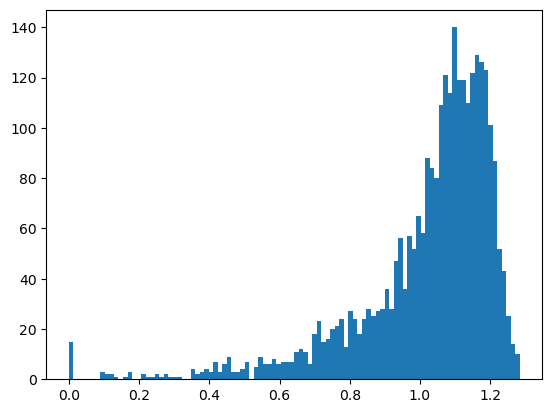

In [21]:
# how to plot a histogram of the distances
plt.hist(df_results['closest_distance'], bins=100)

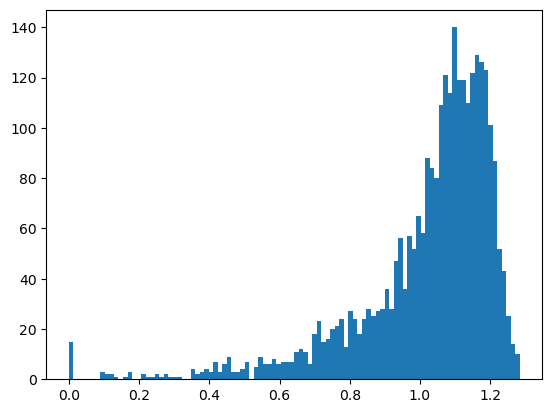

In [22]:
# save the histogram to a png file
plt.hist(df_results['closest_distance'], bins=100)
plt.savefig('histogram.png')



<AxesSubplot:>

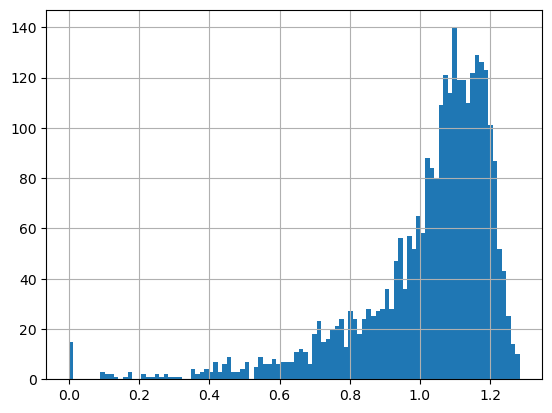

In [23]:
df_results['closest_distance'].hist(bins=100)

<AxesSubplot:title={'center':'closest_distance'}, xlabel='[exam_type]'>

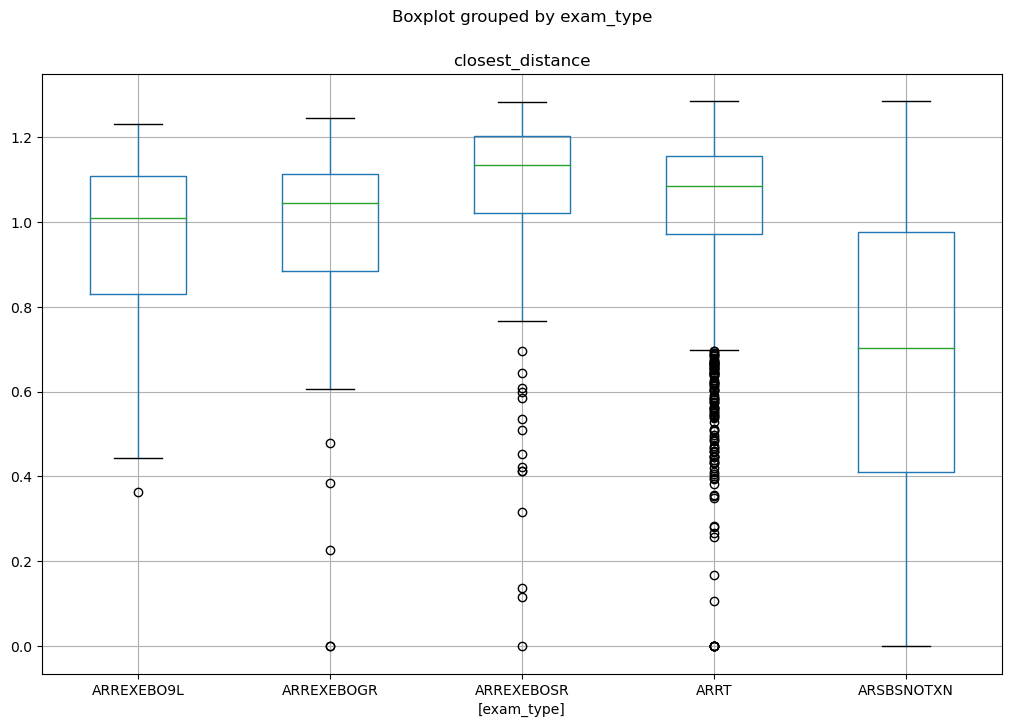

In [24]:
df_results['closest_distance'] 
#boxplot

df_results.boxplot(column=['closest_distance'], by=['exam_type'], figsize=(12, 8))


In [27]:
sample_size = 100
skipped_rows = math.floor(len(df_results)/sample_size)
with open('results_euclidian.txt', 'w') as f:
    for i in range(0, df_results.shape[0], skipped_rows):
        f.write(f'{df_results.iloc[i]["original_text"].encode("utf-8")}\n')
        f.write(f'Entfernung: {df_results.iloc[i]["closest_distance"]}\n')
        f.write(f'{df_results.iloc[i]["closest_text"].encode("utf-8")}\n\n')


In [75]:
def batch_loop(array, batch_size):
    for i in range(0, array.shape[0], batch_size):
        yield array[i:i+batch_size]


(10000, 141650)
(10000, 10000)
[   0  103 5490 ... 4861 1634 4828]


In [35]:
# generators

def square_numbers(nums):
    for i in nums:
        yield (i*i)

square_numbers([1,2,3,4,5])

<generator object square_numbers at 0x7f6b02e1e890>

In [40]:
testgen = square_numbers([1,2,3,4])
next(testgen)
next(testgen)
for i in testgen:
    print(i)

9
16


In [33]:
print((my_nums))
print(next(my_nums))
print(next(my_nums))
print((my_nums))

<generator object square_numbers at 0x7f6b02e1e970>


StopIteration: 

In [34]:
print(next(my_nums))

StopIteration: 